## This notebook calibrates the Cpx-Liq machine learning barometr used by Thermobar. 
- We follow Petrelli, where a different random state is used for pressure and temperature
- Note, this will likely need rerunning a lot, because it seems if sklearn changes version too much, the pickles wont load. 
- With each change in Sklearn, the answer will likely change. The change from v023.2 resulted in a change of up to ~0.8 kbar per Cpx. This is sadly unavoidable as far as we know, although if you have a suggestion please let us know!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import warnings as w
import sys
sys.path.append("../../..")
import Thermobar as pt
pd.set_option('display.max_columns', None)

In [2]:
import sklearn
print(sklearn.__version__)

1.6.1


In [3]:
out_train=pt.import_excel('Jorgenson_Input_filtered.xlsx',
                          sheet_name='Jorgenson_Input_filtered_ThBar')
out_train_input=out_train['my_input']
Cpx_train=out_train['Cpxs']
Liq_train=out_train['Liqs']
Cpx_train_noID_noT=Cpx_train.drop(['Sample_ID_Cpx'], axis=1)
Liq_train_noID_noT=Liq_train#pt.normalize_liquid_jorgenson(liq_comps=Liq_train)
Liq_train_noID_noT.drop(['Sample_ID_Liq',  'Fe3Fet_Liq', 'NiO_Liq',
                                   'CoO_Liq', 'CO2_Liq', 'H2O_Liq'], 
                        axis=1, inplace=True)
Cpx_Liq_Combo_train=pd.concat([Liq_train_noID_noT, Cpx_train_noID_noT], axis=1)
x_train=Cpx_Liq_Combo_train.values
y_train_T=out_train_input['T_K']
y_train_P=out_train_input['P_kbar']

In [4]:
# Scaling
#scaler = StandardScaler().fit(x_train)
x_train_scaled =x_train# scaler.transform(x_train)

# Corin says max features=#*2.3
maxF=int(np.round(21*(2/3), 0))
crit="squared_error"
# Define the regressor, in our case the Extra Tree Regressor
regr_T = ExtraTreesRegressor(n_estimators=201, criterion=crit,
                             max_features=maxF, random_state=280) # random_state fixed for reproducibility

# Define the regressor, in our case the Extra Tree Regressor
regr_P = ExtraTreesRegressor(n_estimators=201, criterion=crit, 
                             max_features=maxF, random_state=80) # random_state fixed for reproducibility

# Train the model
regr_T.fit(x_train_scaled, y_train_T.to_numpy())
regr_P.fit(x_train_scaled, y_train_P.to_numpy())

ExtraTreesRegressor(max_features=14, n_estimators=201, random_state=80)

## These were saved April 24th, 2022. Used in Thermobar until Oct 6th, 2023

In [5]:
# from pickle import dump
# #dump(scaler, open('scaler_Jorg21_Cpx_Liq_April24.pkl', 'wb'))


# import joblib
# joblib.dump(regr_P,  'ETR_Press_Jorg21_Cpx_Liq_April24_NotNorm.pkl',compress=3)

# joblib.dump(regr_T,  'ETR_Temp_Jorg21_Cpx_Liq_April24_NotNorm.pkl',compress=3)

## New Sklearn version saved Oct 6th, 2023
- Asked Jorgenson didnt use a scalar

In [6]:
# from pickle import dump
# #dump(scaler, open('scaler_Jorg21_Cpx_Liq_sklearn_1_3.pkl', 'wb'))


# import joblib
# joblib.dump(regr_P,  'ETR_Press_Jorg21_Cpx_Liq_NotNorm_sklearn_1_3.pkl',compress=3)

# joblib.dump(regr_T,  'ETR_Temp_Jorg21_Cpx_Liq_NotNorm_sklearn_1_3.pkl',compress=3)

## New Sklearn version for 1.6.1 on April 2025

In [7]:
from pickle import dump
#dump(scaler, open('scaler_Jorg21_Cpx_Liq_sklearn_1_3.pkl', 'wb'))


import joblib
joblib.dump(regr_P,  'ETR_Press_Jorg21_Cpx_Liq_NotNorm_sklearn_1_6_1.pkl',compress=3)

joblib.dump(regr_T,  'ETR_Temp_Jorg21_Cpx_Liq_NotNorm_sklearn_1_6_1.pkl',compress=3)

['ETR_Temp_Jorg21_Cpx_Liq_NotNorm_sklearn_1_6_1.pkl']

In [8]:
## Testing recalibration looks okay

In [12]:
## New test data
out_test=pt.import_excel('Jorgenson_Input_filtered.xlsx',
                          sheet_name='New_Test_Data')
out_test_input=out_test['my_input']
Cpx_test=out_test['Cpxs']
Liq_test=out_test['Liqs']

y_test_T=out_test_input['T_K_x']
y_test_P=out_test_input['P_kbar_x']
Temp_Press_Cpx_liq=pt.calculate_cpx_liq_press_temp(cpx_comps=Cpx_test, liq_comps=Liq_test, equationT='T_Jorgenson2022_Cpx_Liq', 
                                               equationP='P_Jorgenson2022_Cpx_Liq')

Temp_Press_Cpx_liq_onnx=pt.calculate_cpx_liq_press_temp(cpx_comps=Cpx_test, liq_comps=Liq_test, equationT='T_Jorgenson2022_Cpx_Liq_onnx', 
                                               equationP='P_Jorgenson2022_Cpx_Liq_onnx')


Temp_Press_Cpx_liq.head()

Im normalizing using the Jorgenson method, e.g. 100 total, 2dp
Im normalizing using the Jorgenson method, e.g. 100 total, 2dp
Youve selected a P-independent function
Youve selected a T-independent function
Youve selected a T-independent function
Im normalizing using the Jorgenson method, e.g. 100 total, 2dp
Im normalizing using the Jorgenson method, e.g. 100 total, 2dp
Youve selected a P-independent function
Youve selected a T-independent function
Youve selected a T-independent function


,P_kbar_calc,T_K_calc,Delta_P_kbar_Iter,Delta_T_K_Iter,Median_Trees_P,Std_Trees_P,IQR_Trees_P,Median_Trees_T,Std_Trees_T,IQR_Trees_T
0,4.684525,1382.174876,0,0,4.996,3.020438,3.020438,1373.15,53.716914,53.716914
1,5.266254,1424.970896,0,0,5.010,3.510207,3.510207,1423.15,52.065953,52.065953
2,5.255478,1408.901244,0,0,5.000,3.073712,3.073712,1413.15,56.414756,56.414756
3,5.302085,1395.786816,0,0,5.000,3.666123,3.666123,1403.15,48.231742,48.231742
4,5.505522,1377.552985,0,0,5.000,3.776594,3.776594,1373.15,54.115427,54.115427


In [13]:
Temp_Press_Cpx_liq_onnx

,P_kbar_calc,T_K_calc,Delta_P_kbar_Iter,Delta_T_K_Iter
0,4.684525,1382.368896,0,0
1,5.266253,1423.358887,0,0
2,5.255477,1408.274292,0,0
3,5.302085,1397.881470,0,0
4,5.505522,1373.945923,0,0
...,...,...,...,...
165,2.688612,1293.296753,0,0
166,2.963800,1285.139893,0,0
167,3.656099,1281.249512,0,0
168,2.826084,1231.772095,0,0


0.06551246707638146
RMSE
2.27552
27.069139596133347
RMSE
48.14


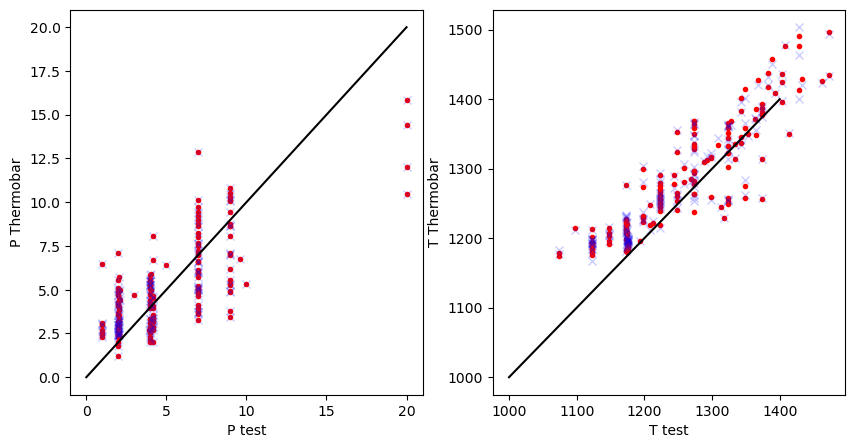

In [17]:
## Testing Cpx-only pressure and temp. 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(y_test_P, Temp_Press_Cpx_liq['P_kbar_calc'], '.r' , label='Pkl')
ax1.plot(y_test_P, Temp_Press_Cpx_liq_onnx['P_kbar_calc'], 'xb', alpha=0.2 , label='Onnx')

ax1.set_xlabel('P test')
ax1.set_ylabel('P Thermobar')
ax1.plot([0, 20], [0, 20], '-k')
stats_P=pt.calculate_R2(y_test_P, Temp_Press_Cpx_liq['P_kbar_calc'])
print('RMSE')
print(stats_P['RMSE_num'])

ax2.plot(y_test_T, Temp_Press_Cpx_liq['T_K_calc'], '.r' )
ax2.plot(y_test_T, Temp_Press_Cpx_liq_onnx['T_K_calc'], 'xb', alpha=0.2 )
ax2.set_xlabel('T test')
ax2.set_ylabel('T Thermobar')
ax2.plot([1000, 1400], [1000, 1400], '-k')
stats_T=pt.calculate_R2(y_test_T, Temp_Press_Cpx_liq['T_K_calc'])
print('RMSE')
print(stats_T['RMSE'])
plt.show()